In [1]:
import atoti as tt

Welcome to Atoti 0.8.10!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


In [289]:
session = tt.Session(
    user_content_storage=".content",
    port=9095,
    java_options=["-Xms1G", "-Xmx10G"]
)

Closing existing "Unnamed" session to create the new one.


In [290]:
db_name = "Project1"
db_user = "postgres"
db_password = "postgres"  
db_host = "localhost"  
db_port = "5432"

In [291]:
jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

In [292]:
jdbc_url

'jdbc:postgresql://localhost:5432/Project1?user=postgres&password=postgres'

In [293]:
facttest = session.read_sql(
    "SELECT * FROM olympics",
    keys=["factid"],
    table_name="factTable",
    url=jdbc_url,
)

In [294]:
facttest.head()

,year,country,bronze,gold,silver,code,depression,schizophrenia,bipolar,eatingdisorder,anxiety
factid,,,,,,,,,,,
4,1992,Austria,8,6,10,AUT,623.6259,174.99193,193.4572,91.35018,551.77155
16,1992,Finland,5,4,3,FIN,869.3975,167.26642,194.50778,91.90733,384.8344
24,1992,Israel,1,0,1,ISR,823.34717,193.19022,226.66081,64.53508,356.16626
32,1992,Malaysia,2,0,0,MYS,526.3468,193.75183,73.24124,24.406479,423.08075
40,1992,Norway,6,11,10,NOR,508.43967,179.30298,179.03253,89.34628,684.3087


In [295]:
# medals = session.read_sql(
#     "SELECT * FROM medalsnew",
#     keys=["id"],
#     table_name="Medals",
#     url=jdbc_url)

In [296]:
countries = session.read_sql(
    "SELECT * FROM countries",
    keys=["country"],
    table_name="Countries",
    url=jdbc_url)

In [226]:
illness = session.read_sql(
    "SELECT * FROM mentalillness",
    keys=["code","year"],
    table_name="Illness",
    url=jdbc_url)

In [297]:
time = session.read_sql(
    "SELECT * FROM timex",
    keys=["year"],
    table_name="Time",
    url=jdbc_url)

In [299]:
facttest.join(countries, facttest["country"] == countries["country"])

In [230]:
facttest.join(illness, (facttest["year"] == illness["year"] )& (facttest["code"] == illness["code"]))

In [300]:
facttest.join(time, facttest["year"] == time["year"])

In [301]:
session.tables.schema

```mermaid
erDiagram
  "Countries" {
    _ String PK "country"
    _ String "continent"
  }
  "Time" {
    _ int PK "year"
  }
  "factTable" {
    _ int PK "factid"
    nullable int "year"
    _ String "country"
    nullable int "bronze"
    nullable int "gold"
    nullable int "silver"
    _ String "code"
    nullable double "depression"
    nullable double "schizophrenia"
    nullable double "bipolar"
    nullable double "eatingdisorder"
    nullable double "anxiety"
  }
  "factTable" }o--o| "Countries" : "`country` == `country`"
  "factTable" }o--o| "Time" : "`year` == `year`"
```


In [302]:
testcube = session.create_cube(facttest)

In [303]:
testcube.measures['total.SUM'] = testcube.measures['gold.SUM'] + testcube.measures['silver.SUM'] + testcube.measures['bronze.SUM']

In [304]:
testcube

In [305]:
hierarchies, levels, measures = testcube.hierarchies, testcube.levels, testcube.measures

In [306]:
print(list(testcube.levels))

[('factTable', 'code', 'code'), ('Countries', 'continent', 'continent'), ('factTable', 'factid', 'factid'), ('factTable', 'country', 'country')]


In [307]:
hierarchies

{('factTable', 'code'): <atoti.hierarchy.Hierarchy object at 0x7dcfb431eec0>, ('Countries', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7dcfb431eef0>, ('factTable', 'factid'): <atoti.hierarchy.Hierarchy object at 0x7dcf84498250>, ('factTable', 'country'): <atoti.hierarchy.Hierarchy object at 0x7dcf8449bf70>}

In [308]:
testcube.levels

In [309]:
testcube.hierarchies["Time", "year"]= [time["year"]]

In [311]:
testcube.query(measures["total.SUM"],measures["depression.SUM"], levels=[levels["Countries",'continent','continent']])

,total.SUM,depression.SUM
continent,,
Africa,257,"57,440.43"
Asia,653,"69,170.59"
Europe,"3,666","188,134.71"
North America,615,"37,316.22"
Oceania,434,"18,192.94"
South America,194,"18,861.15"


In [286]:
testcube.query(measures["total.SUM"],measures["depression.SUM"], levels=[levels["Time","year","year"],levels["Countries",'country','country']],filter=(levels["Countries",'country','country']== "Ireland"))

,,total.SUM,depression.SUM
year,country,,
1992,Ireland,2,720.62
1996,Ireland,4,730.01
2000,Ireland,1,748.26
2008,Ireland,3,745.59
2012,Ireland,6,727.25
2016,Ireland,3,730.80


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
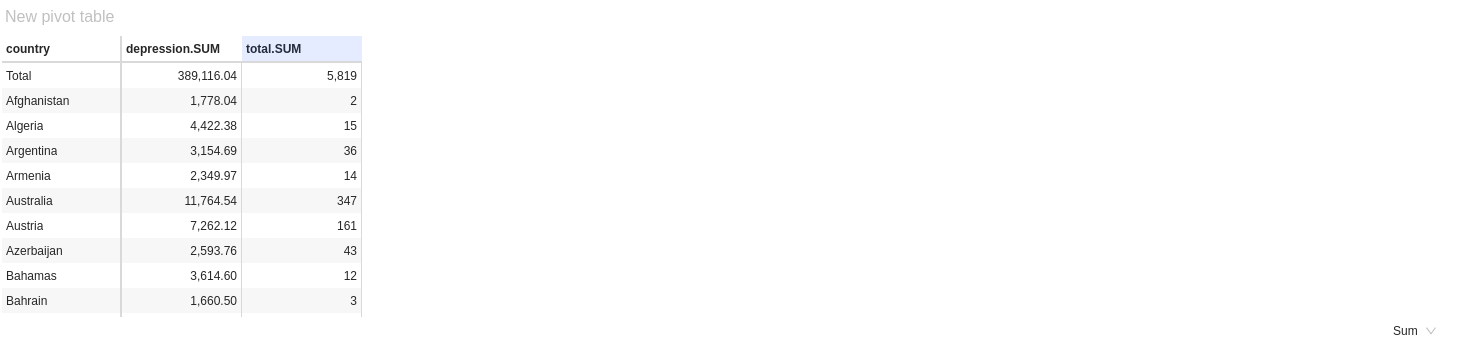

In [269]:
session.widget